# Toronto neighborhood analysis project

##Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Step 1. Downloading the neighborhood data
In this step we will download Toronto neighborhood data and create a dataframe for further manipulations

###Scraping data from WikiPedia
We will use the table from following link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Read the table and save it as a dataframe

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


###Create a final dataframe

Let's fined the rows that with "Not assigned" Boroughs...

In [0]:
ix=df[df.Borough == 'Not assigned'].index

...and drop them

In [4]:
# Drop rows
df.drop(ix, inplace=True)
# Sort by Postal code
df.sort_values(by=['Postal Code'], inplace=True)
# Reset index
df.reset_index(inplace=True, drop=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
df.columns

Index(['Postal Code', 'Borough', 'Neighborhood'], dtype='object')

### Saving the dataframe 
DEAR EVALUATORS, IGNORE THE CODE BELOW.

I'm using Google Colab to run my Notebook and next lines of code are used to save the results in Google Drive

In [0]:
df.to_csv('df-toronto-neihgborhoods.csv', index=False)
df.to_excel('df-toronto-neihgborhoods.xlsx', index=False)

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#!cp -r df-toronto-neihgborhoods.xlsx drive/My\ Drive/Colab/ML-clustering-toronto-neighborhoods/df-toronto-neihgborhoods.xlsx
#!cp -r df-toronto-neihgborhoods.csv drive/My\ Drive/Colab/ML-clustering-toronto-neighborhoods/df-toronto-neihgborhoods.csv

## Step 2: Get latitude and longitude coordinates
Next we get lat and long coordinates for each neighborhood.

### First we gonna read the csv file with Ontario postal codes and related coordinates

In [9]:
postal_df =  pd.read_csv('http://cocl.us/Geospatial_data')
postal_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Next we gonna merge newly obtained data with our dataframe based on Postal code matching

In [10]:
df = df.merge(postal_df, how='left', on='Postal Code', copy=True)
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Saving data to Google drive

In [0]:
df.to_csv('df-toronto-neihgborhoods-postalcodes.csv', index=False)
df.to_excel('df-toronto-neihgborhoods-postalcodes.xlsx', index=False)

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#!cp -r df-toronto-neihgborhoods-postalcodes.xlsx drive/My\ Drive/Colab/ML-clustering-toronto-neighborhoods/df-toronto-neihgborhoods-postalcodes.xlsx
#!cp -r df-toronto-neihgborhoods-postalcodes.csv drive/My\ Drive/Colab/ML-clustering-toronto-neighborhoods/df-toronto-neihgborhoods-postalcodes.csv

## Step 3. Neighborhood analysis
Lets' analyse the Toronto neughborhoods

We will focus on Boroughs that contain Toronto in their name

In [14]:
df = df[df['Borough'].str.contains("Toronto")]
df.reset_index(inplace=True, drop=True)
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [15]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
# create map of Toronto using latitude and longitude values
latitude
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Define Foursquare credentials and Version

In [0]:
CLIENT_ID = 'HOGPJE3HEQSUCCOHACGSFU22DYGFV4NM3VG2WELOIHXBH0QF' # your Foursquare ID (fake)
CLIENT_SECRET = 'Y0DLYDDF2YBRYE2IITVXVPLIYZ4YAAI2VR0FEKDKZ3UDB1MA' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version
LIMIT=100

### Explore Toronto neighborhoods

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'],longitudes=df['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

### Let's check the returned venues

In [23]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


Number of venues for each neighborhood

In [24]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",18,18,18,18,18,18
Central Bay Street,65,65,65,65,65,65
Christie,16,16,16,16,16,16
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,31,31,31,31,31,31


Number of unique categories from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


### Analyze each neighborhood

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
columns = toronto_onehot.columns.to_list()
columns.remove('Neighborhood') # somehow Neighborhood column appearing in the middle of the df
# rearrange columns
columns.insert(0,'Neighborhood')
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
toronto_onehot = toronto_onehot[columns]
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
toronto_onehot.shape

(1618, 237)

**Next**, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [28]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.0000,0.017857,0.0000,0.017857,0.035714,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.0000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.017857,0.053571,0.071429,0.000000,0.00000,0.000000,0.00,0.000000,0.017857,0.000000,0.017857,0.000000,0.00,0.000000,0.00000,0.017857,0.000000,0.000000,0.000000,0.0

In [29]:
toronto_grouped.shape

(39, 237)

Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3            Beer Bar  0.04
4          Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
               venue  freq
0               Café  0.13
1     Breakfast Spot  0.09
2        Coffee Shop  0.09
3             Bakery  0.09
4  Convenience Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.06
1               Brewery  0.06
2            Skate Park  0.06
3            Restaurant  0.06
4           Pizza Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.17
1       Airport Lounge  0.11
2     Airport Terminal  0.11
3             Boutique  0.06
4  Rental Car Location  0.06


----Central Bay Street----


Let's put that into a pandas dataframe

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Café,Clothing Store,Irish Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Gym,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Comic Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Rental Car Location,Harbor / Marina,Plane,Boat or Ferry,Boutique,Bar,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Department Store,Salad Place,Burger Joint,Bubble Tea Shop,Indian Restaurant


## Step 4. Cluster neighborhoods

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9794151d30>,
                 k=None, metric=None, model=None, timings=True)

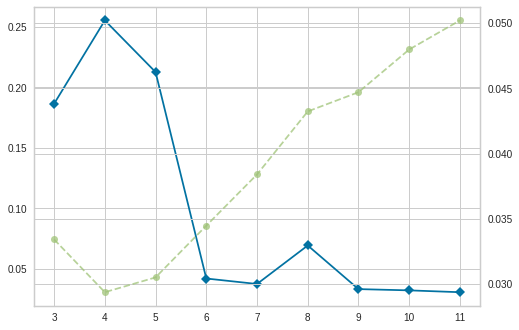

In [63]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(3,12))
visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer

In [64]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 5, 0, 1, 0,
       0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [34]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Café,Clothing Store,Irish Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Gym,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Comic Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Rental Car Location,Harbor / Marina,Plane,Boat or Ferry,Boutique,Bar,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Department Store,Salad Place,Burger Joint,Bubble Tea Shop,Indian Restaurant


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df.drop(columns='Postal Code')

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,43.676357,-79.293031,2,Trail,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bubble Tea Shop,Spa
2,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,Sandwich Place,Fast Food Restaurant,Gym,Pet Store,Brewery,Burrito Place,Restaurant,Pub,Pizza Place,Movie Theater
3,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Brewery,Gastropub,Bakery,American Restaurant,Convenience Store,Seafood Restaurant,Sandwich Place,Cheese Shop
4,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


Finally, let's visualize the resulting clusters

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine clusters

Cluster 0 (red dots) have a lot of cafes and coffee *shops*

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lawrence Park,Park,Swim School,Bus Line,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
8,"Moore Park, Summerhill East",Gym,Park,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
10,Rosedale,Park,Playground,Trail,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


Cluster 1 (purple dots) have are located next to parks

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Roselawn,Ice Cream Shop,Home Service,Garden,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio,Dim Sum Restaurant


Cluster 2 (green dot) is ... no idea :)

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,Trail,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bubble Tea Shop,Spa
2,"India Bazaar, The Beaches West",Sandwich Place,Fast Food Restaurant,Gym,Pet Store,Brewery,Burrito Place,Restaurant,Pub,Pizza Place,Movie Theater
3,Studio District,Café,Coffee Shop,Brewery,Gastropub,Bakery,American Restaurant,Convenience Store,Seafood Restaurant,Sandwich Place,Cheese Shop
5,Davisville North,Gym,Hotel,Park,Food & Drink Shop,Sandwich Place,Department Store,Breakfast Spot,Gym / Fitness Center,Pizza Place,Convention Center
6,"North Toronto West, Lawrence Park",Clothing Store,Coffee Shop,Yoga Studio,Chinese Restaurant,Spa,Sporting Goods Shop,Diner,Fast Food Restaurant,Salon / Barbershop,Café
7,Davisville,Dessert Shop,Sandwich Place,Sushi Restaurant,Café,Pizza Place,Coffee Shop,Gym,Italian Restaurant,Farmers Market,Diner
9,"Summerhill West, Rathnelly, South Hill, Forest...",Coffee Shop,Light Rail Station,Pub,Pizza Place,Bank,Bagel Shop,Restaurant,Fried Chicken Joint,Sports Bar,Supermarket
11,"St. James Town, Cabbagetown",Café,Coffee Shop,Pizza Place,Restaurant,Bakery,Italian Restaurant,Pub,Park,Chinese Restaurant,Sandwich Place
12,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Café,Pub,Men's Store,Mediterranean Restaurant,Hotel
